In [1]:
# Author: Matthieu RASOLOVOAHANGY
# Student Number: 72251

In [47]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel# Use RandomForest for feature importance
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
import platform
import optuna
import joblib

print(sklearn.__version__)
print(platform.python_version())

1.2.2
3.10.9


In [3]:
# Load datasets
credit_df = pd.read_csv('credit_record.csv')
label_df = pd.read_csv('application_record.csv')

In [4]:
# Merge dataframes
df = label_df.merge(credit_df, how='inner', on=['ID'])
df.set_index('ID', inplace=True)
df.drop_duplicates(inplace=True)
df.head()

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                               
5008804           M            Y               Y             0   
5008804           M            Y               Y             0   
5008804           M            Y               Y             0   
5008804           M            Y               Y             0   
5008804           M            Y               Y             0   

         AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
ID                                                               
5008804          427500.0          Working    Higher education   
5008804          427500.0          Working    Higher education   
5008804          427500.0          Working    Higher education   
5008804          427500.0          Working    Higher education   
5008804          427500.0          Working    Higher education   

        NAME_FAMILY_STATUS NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
ID                                                                        
5008804     Civil marriage  Rented apartment      -12005          -4542   
5008804     Civil marriage  Rented apartment      -12005          -4542   
5008804     Civil marriage  Rented apartment      -12005          -4542   
5008804     Civil marriage  Rented apartment      -12005          -4542   
5008804     Civil marriage  Rented apartment      -12005          -4542   

         FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
ID                                                                             
5008804           1                1           0           0             NaN   
5008804           1                1           0           0             NaN   
5008804           1                1           0           0             NaN   
5008804           1                1           0           0             NaN   
5008804           1                1           0           0             NaN   

         CNT_FAM_MEMBERS  MONTHS_BALANCE STATUS  
ID                                               
5008804              2.0               0      C  
5008804              2.0              -1      C  
5008804              2.0              -2      C  
5008804              2.0              -3      C  
5008804              2.0              -4      C

In [5]:
# Calculate the percentage of missing values for each column
missing_percent = df.isnull().sum() * 100 / len(df)

In [6]:
# Define a threshold for dropping columns
threshold = 30.0

In [7]:
# Find and drop the columns with missing value percent greater than the threshold
df.info()
for column, percent in missing_percent.items():
    if percent > threshold and column in df.columns:
        df.drop(column, axis=1, inplace=True)
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468925 entries, 5008804 to 5150337
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODE_GENDER          468925 non-null  object 
 1   FLAG_OWN_CAR         468925 non-null  object 
 2   FLAG_OWN_REALTY      468925 non-null  object 
 3   CNT_CHILDREN         468925 non-null  int64  
 4   AMT_INCOME_TOTAL     468925 non-null  float64
 5   NAME_INCOME_TYPE     468925 non-null  object 
 6   NAME_EDUCATION_TYPE  468925 non-null  object 
 7   NAME_FAMILY_STATUS   468925 non-null  object 
 8   NAME_HOUSING_TYPE    468925 non-null  object 
 9   DAYS_BIRTH           468925 non-null  int64  
 10  DAYS_EMPLOYED        468925 non-null  int64  
 11  FLAG_MOBIL           468925 non-null  int64  
 12  FLAG_WORK_PHONE      468925 non-null  int64  
 13  FLAG_PHONE           468925 non-null  int64  
 14  FLAG_EMAIL           468925 non-null  int64  
 15  OCCUPATION

CNT_CHILDREN  AMT_INCOME_TOTAL     DAYS_BIRTH  DAYS_EMPLOYED  \
count  468925.000000      4.689250e+05  468925.000000  468925.000000   
mean        0.421415      1.858502e+05  -16158.295521   60224.031389   
std         0.747775      1.009916e+05    4130.224148  138588.126971   
min         0.000000      2.700000e+04  -25152.000000  -15713.000000   
25%         0.000000      1.215000e+05  -19584.000000   -3246.000000   
50%         0.000000      1.575000e+05  -15812.000000   -1610.000000   
75%         1.000000      2.250000e+05  -12724.000000    -398.000000   
max        19.000000      1.575000e+06   -7489.000000  365243.000000   

       FLAG_MOBIL  FLAG_WORK_PHONE     FLAG_PHONE     FLAG_EMAIL  \
count    468925.0    468925.000000  468925.000000  468925.000000   
mean          1.0         0.225379       0.297472       0.089230   
std           0.0         0.417832       0.457146       0.285075   
min           1.0         0.000000       0.000000       0.000000   
25%           1.0         0.000000       0.000000       0.000000   
50%           1.0         0.000000       0.000000       0.000000   
75%           1.0         0.000000       1.000000       0.000000   
max           1.0         1.000000       1.000000       1.000000   

       CNT_FAM_MEMBERS  MONTHS_BALANCE  
count    468925.000000   468925.000000  
mean          2.197081      -20.979513  
std           0.910155       14.680523  
min           1.000000      -60.000000  
25%           2.000000      -32.000000  
50%           2.000000      -19.000000  
75%           3.000000       -8.000000  
max          20.000000        0.000000

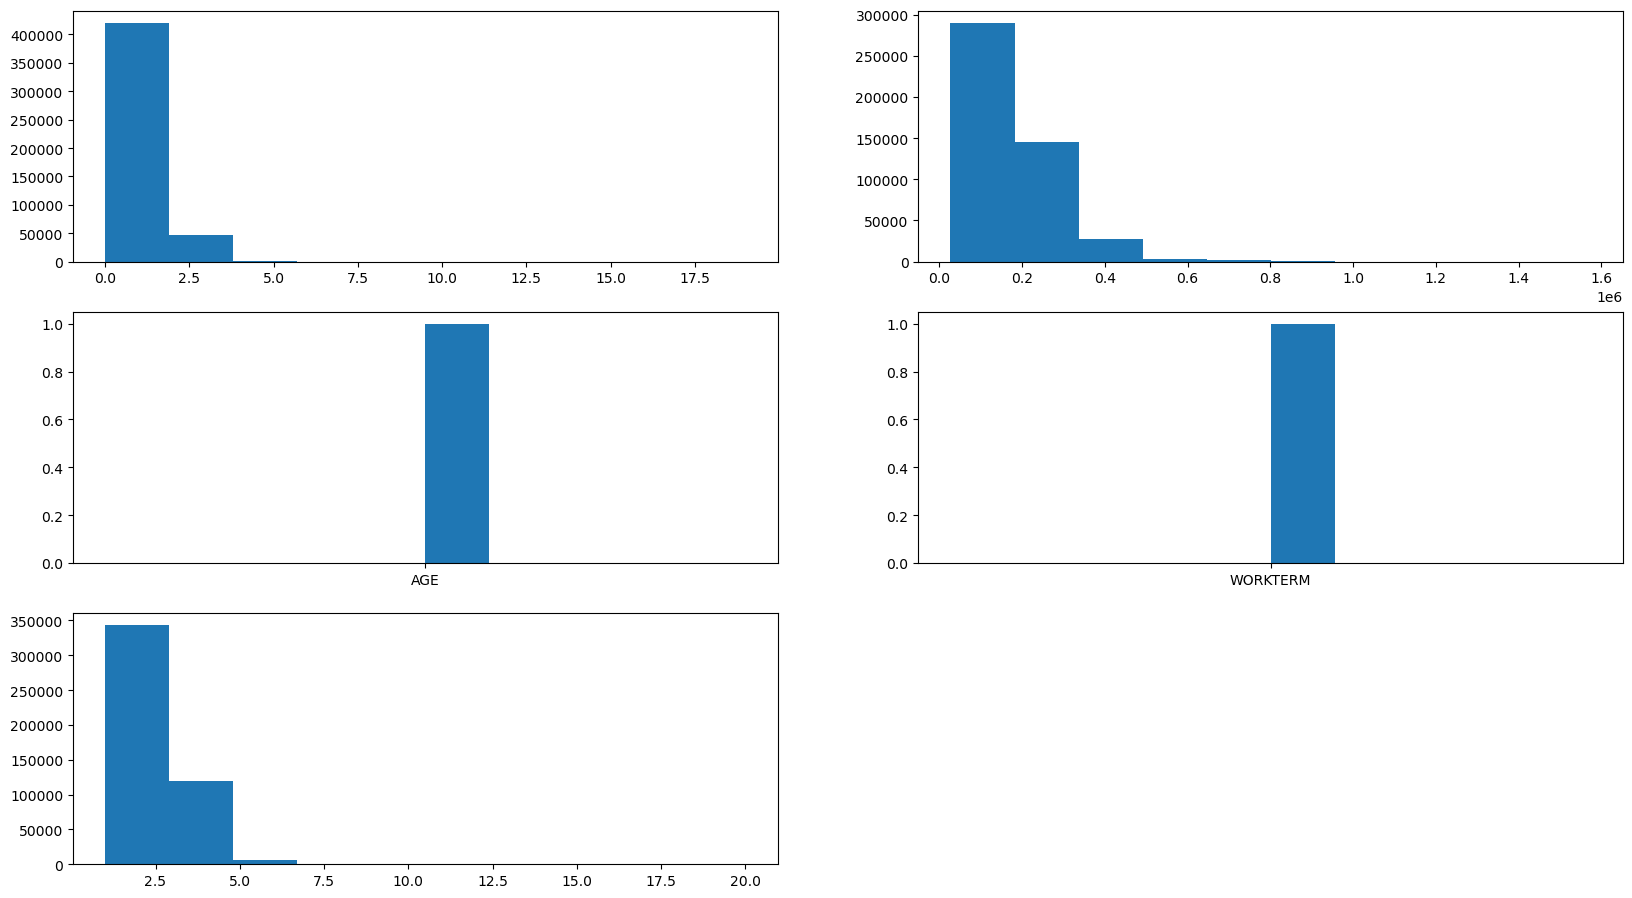

In [8]:
# Histograms (https://www.kaggle.com/code/jainprathik/random-forest-and-xgboost-with-op?scriptVersionId=118603204&cellId=27)
plt.figure(figsize=[20,15])
plt.subplot(4,2,1)
plt.hist(data= df, x='CNT_CHILDREN')
plt.subplot(4,2,2)
plt.hist(data= df, x='AMT_INCOME_TOTAL')
plt.subplot(4,2,3)
plt.hist(data= df, x='AGE')
plt.subplot(4,2,4)
plt.hist(data= df, x='WORKTERM')
plt.subplot(4,2,5)
plt.hist(data= df, x='CNT_FAM_MEMBERS')
plt.show()

In [9]:
# Getting unique values from each features
for i in df.columns:
    print(i,'-',df[i].unique())

CODE_GENDER - ['M' 'F']
FLAG_OWN_CAR - ['Y' 'N']
FLAG_OWN_REALTY - ['Y' 'N']
CNT_CHILDREN - [ 0  1  3  2  4  5 14 19  7]
AMT_INCOME_TOTAL - [ 427500.   112500.   270000.   283500.   135000.   130500.   157500.
  405000.   211500.   360000.   126000.   315000.   247500.   297000.
  225000.   166500.   216000.   255150.   148500.   202500.    94500.
  450000.   180000.    90000.   765000.   382500.   144000.   229500.
  292500.    74250.    40500.   337500.   193500.   267750.   139500.
   67500.   252000.   900000.   115290.   279000.    76500.   234000.
   81000.   108000.    99000.   198000.    45000.   238500.   117000.
  153000.  1350000.   445500.   495000.    85500.   306000.   562500.
  189000.   328500.   310500.   540000.   171000.   675000.   121500.
   72000.    65250.   184500.   103500.   162000.   165150.    54000.
  243000.   256500.    33300.   697500.   101250.    58500.   110250.
  472500.   196650.   630000.   432000.   257625.   143100.   207000.
  288000.   131400. 

In [10]:
# Perform necessary data transformations
df['AGE'] = -(df['DAYS_BIRTH']) // 365
df['WORKTERM'] = -(df['DAYS_EMPLOYED']) // 365
df['WORKTERM'] = df['WORKTERM'].replace(-1001, -1)
df.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)
df['STATUS'].replace({'C': 6, 'X' : 7}, inplace=True)
df['STATUS'] = df['STATUS'].astype(int)
df['LABEL'] = df['STATUS'].apply(lambda status: 1 if status in (2,3,4,5) else 0)
df.drop('STATUS', axis=1, inplace=True)
df.dropna(inplace=True)

CNT_CHILDREN         2.822807
AMT_INCOME_TOTAL     2.668338
FLAG_MOBIL           0.000000
FLAG_WORK_PHONE      1.314507
FLAG_PHONE           0.886058
FLAG_EMAIL           2.881851
CNT_FAM_MEMBERS      1.438902
MONTHS_BALANCE      -0.483808
AGE                  0.157029
WORKTERM             1.650938
LABEL               13.455227
dtype: float64

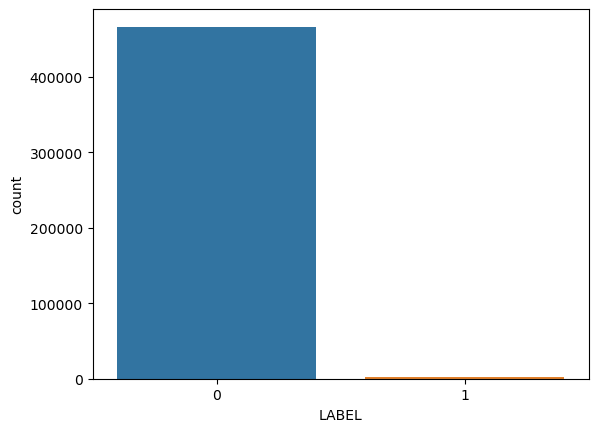

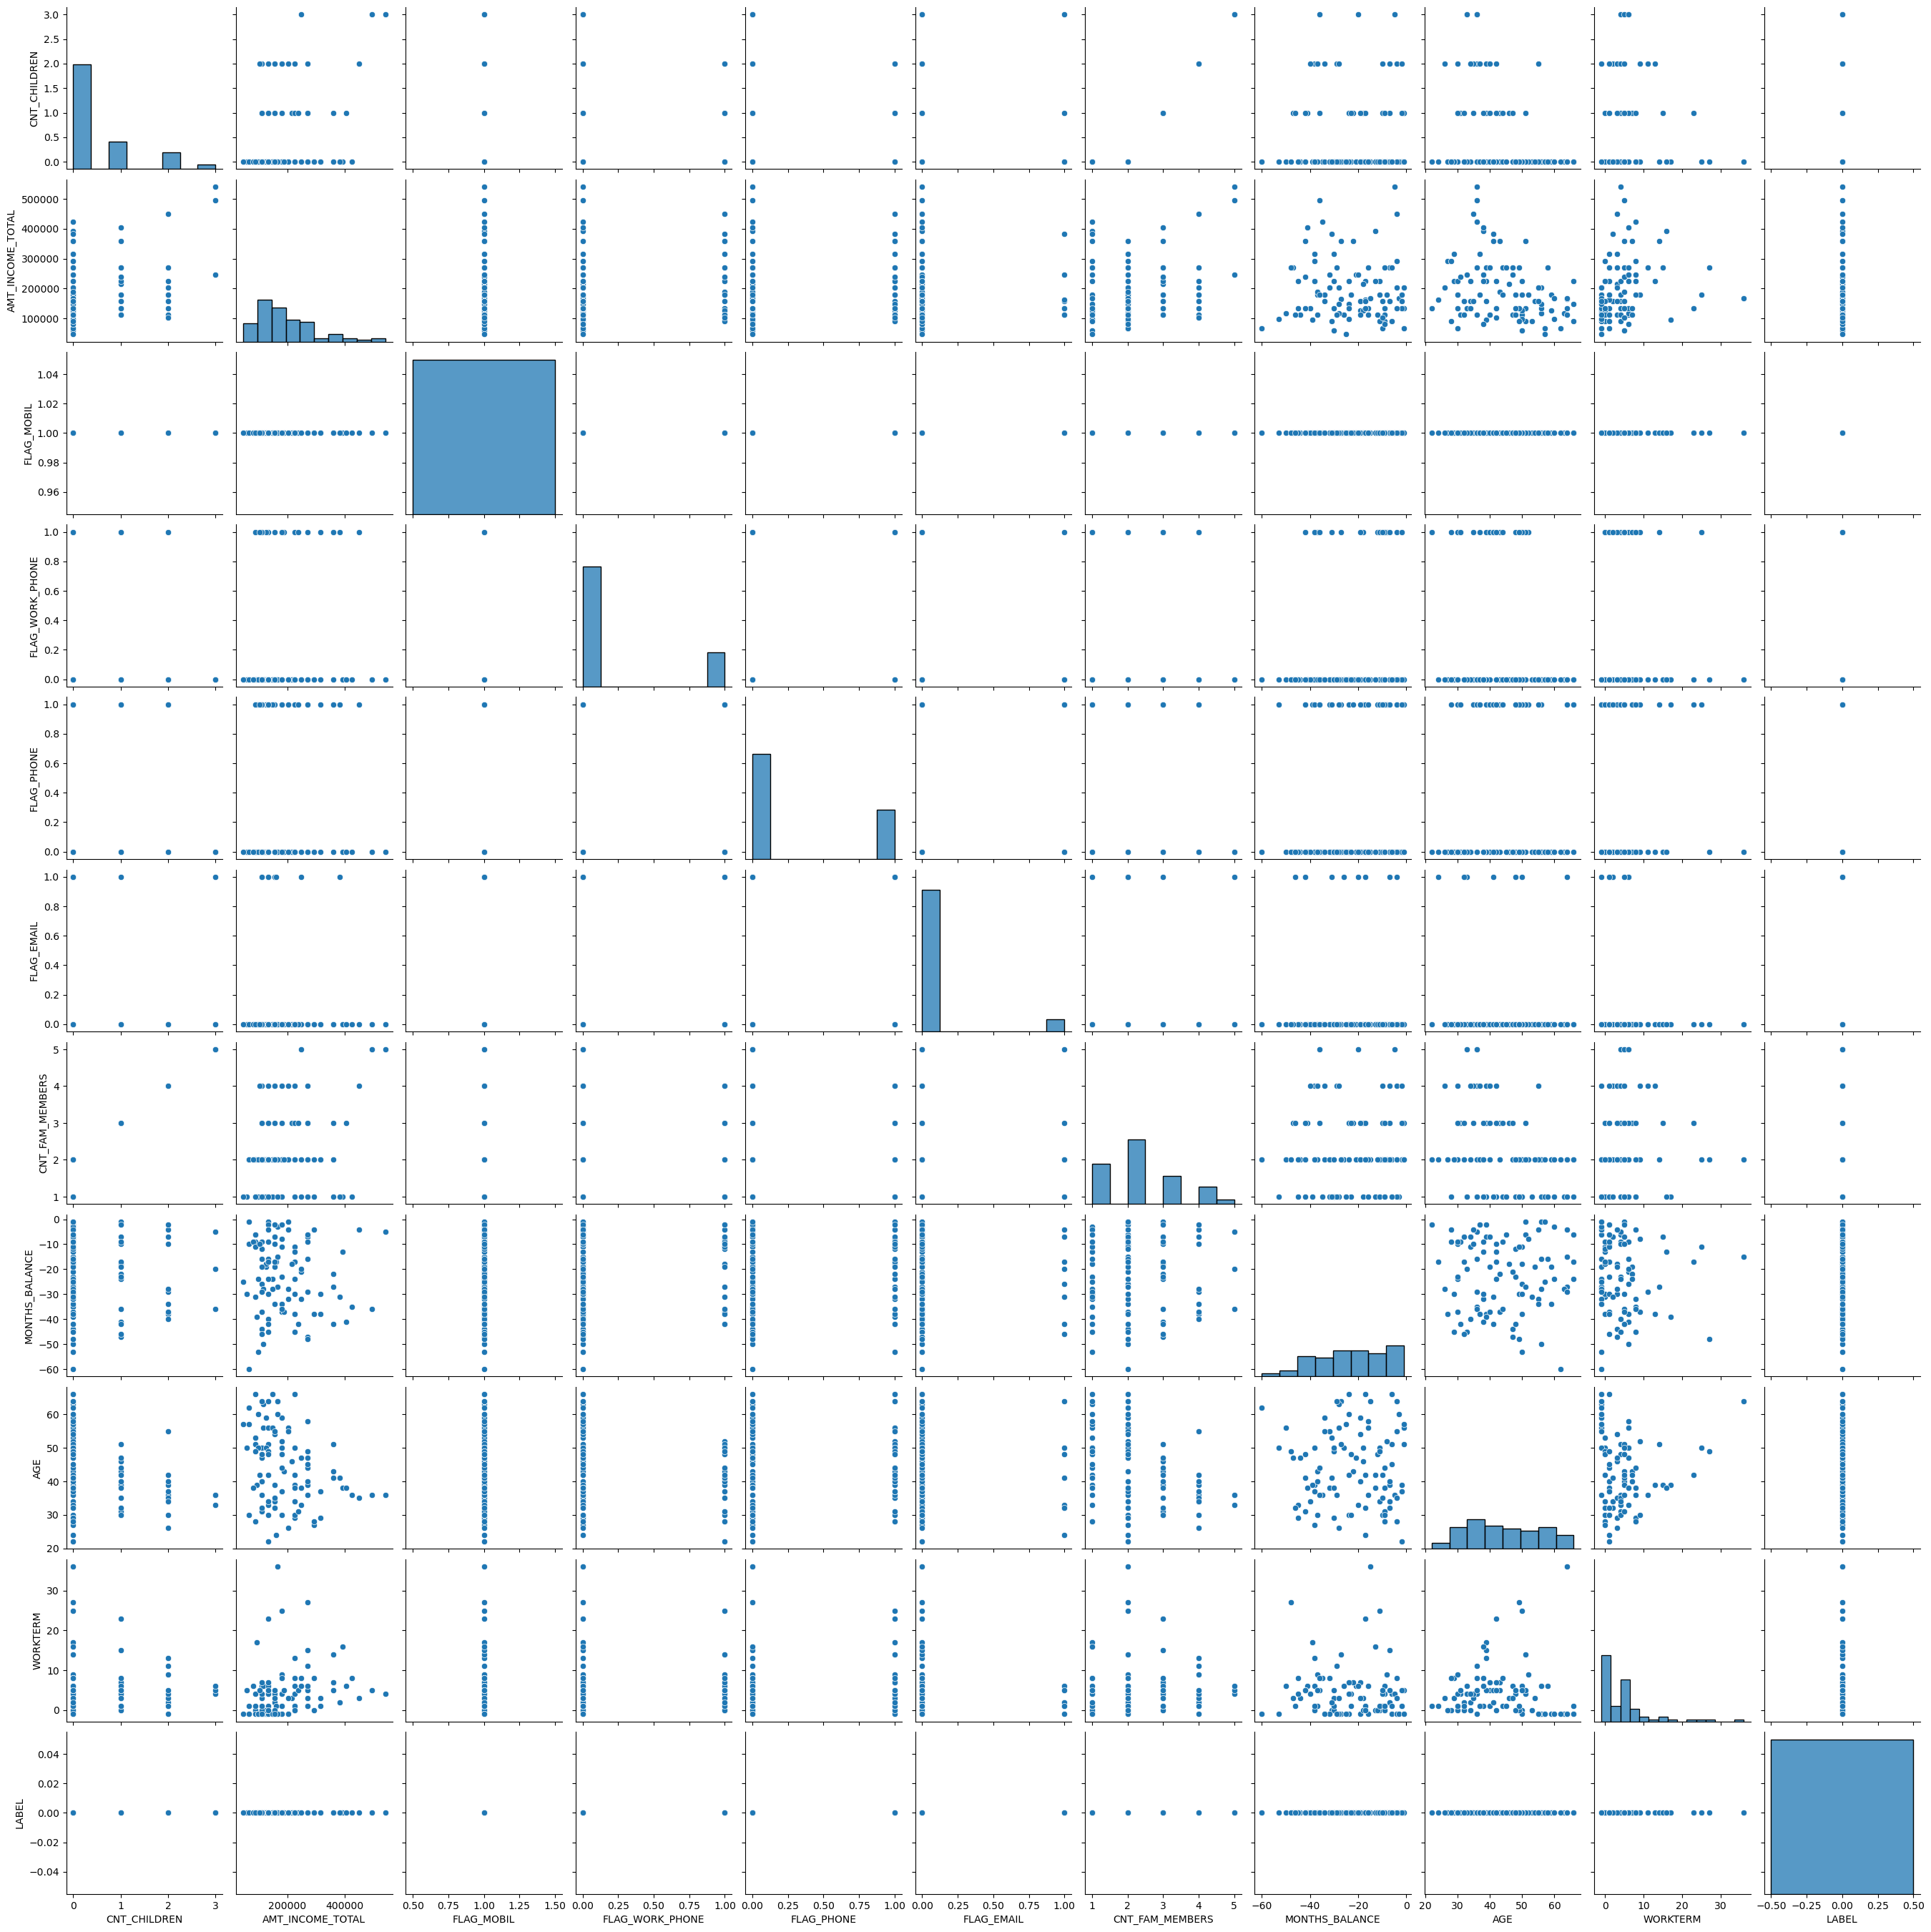

In [11]:
# Frequency count of each category in the "LABEL" column
sns.countplot(x=df["LABEL"])
sns.pairplot(df.sample(100))
df.skew(numeric_only=True)

In [12]:
# Compute the correlation matrix
df_corr = df.corr(method='spearman', numeric_only=True)

In [13]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

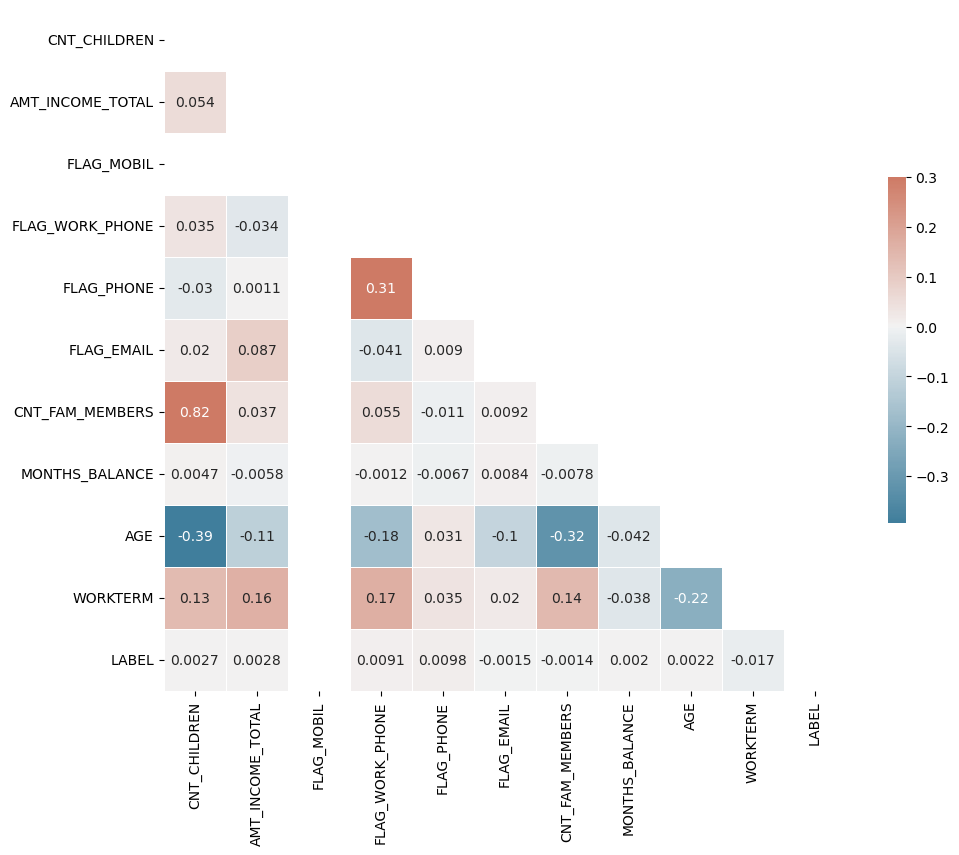

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

In [15]:
# https://www.kaggle.com/code/jainprathik/random-forest-and-xgboost-with-op?scriptVersionId=118603204&cellId=30
plt.figure(figsize=(5, 5))
sns.countplot(x='CODE_GENDER', data=df, hue='LABEL')
plt.title('Distribution of each gender')
plt.show()

In [16]:
plt.figure(figsize=(5,5))
sns.countplot(x='FLAG_OWN_CAR', data=df,hue='LABEL')
plt.title('Distribution of Car Owner or Not')
plt.show()

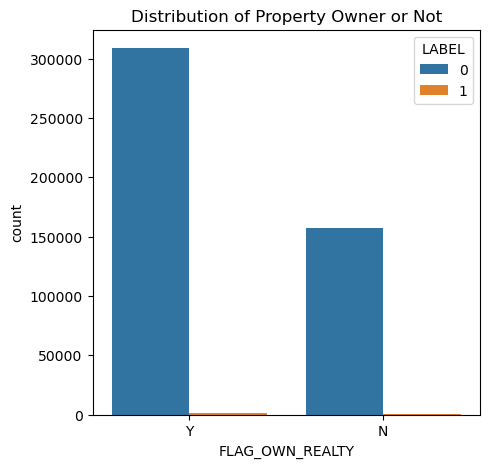

In [17]:
plt.figure(figsize=(5,5))
sns.countplot(x='FLAG_OWN_REALTY', data=df,hue='LABEL')
plt.title('Distribution of Property Owner or Not')
plt.show()

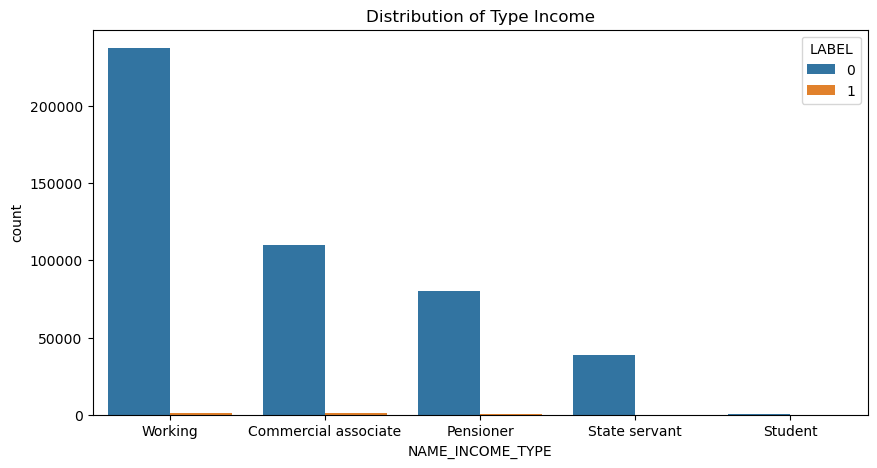

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(x='NAME_INCOME_TYPE', data=df,hue='LABEL')
plt.title('Distribution of Type Income')
plt.show()

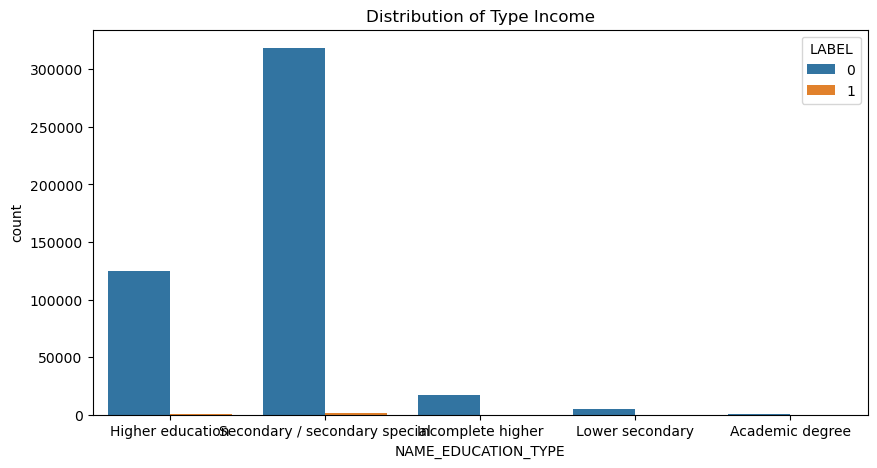

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(x='NAME_EDUCATION_TYPE', data=df,hue='LABEL')
plt.title('Distribution of Type Income')
plt.show()

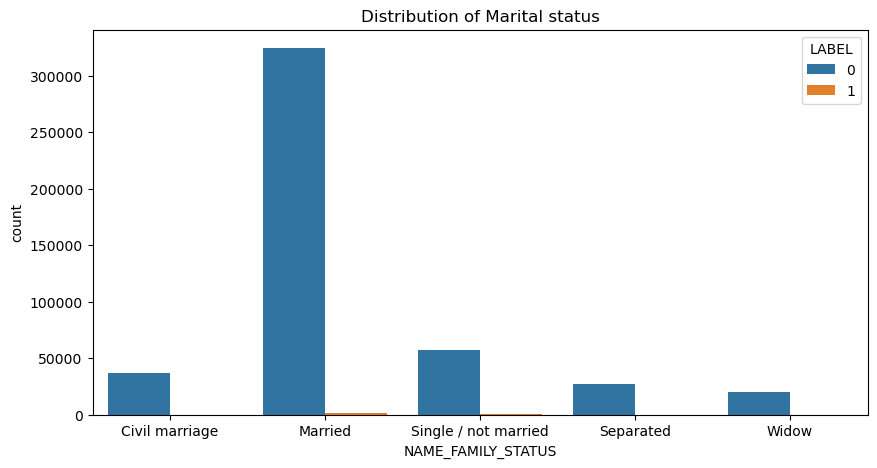

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(x='NAME_FAMILY_STATUS', data=df,hue='LABEL')
plt.title('Distribution of Marital status')
plt.show()

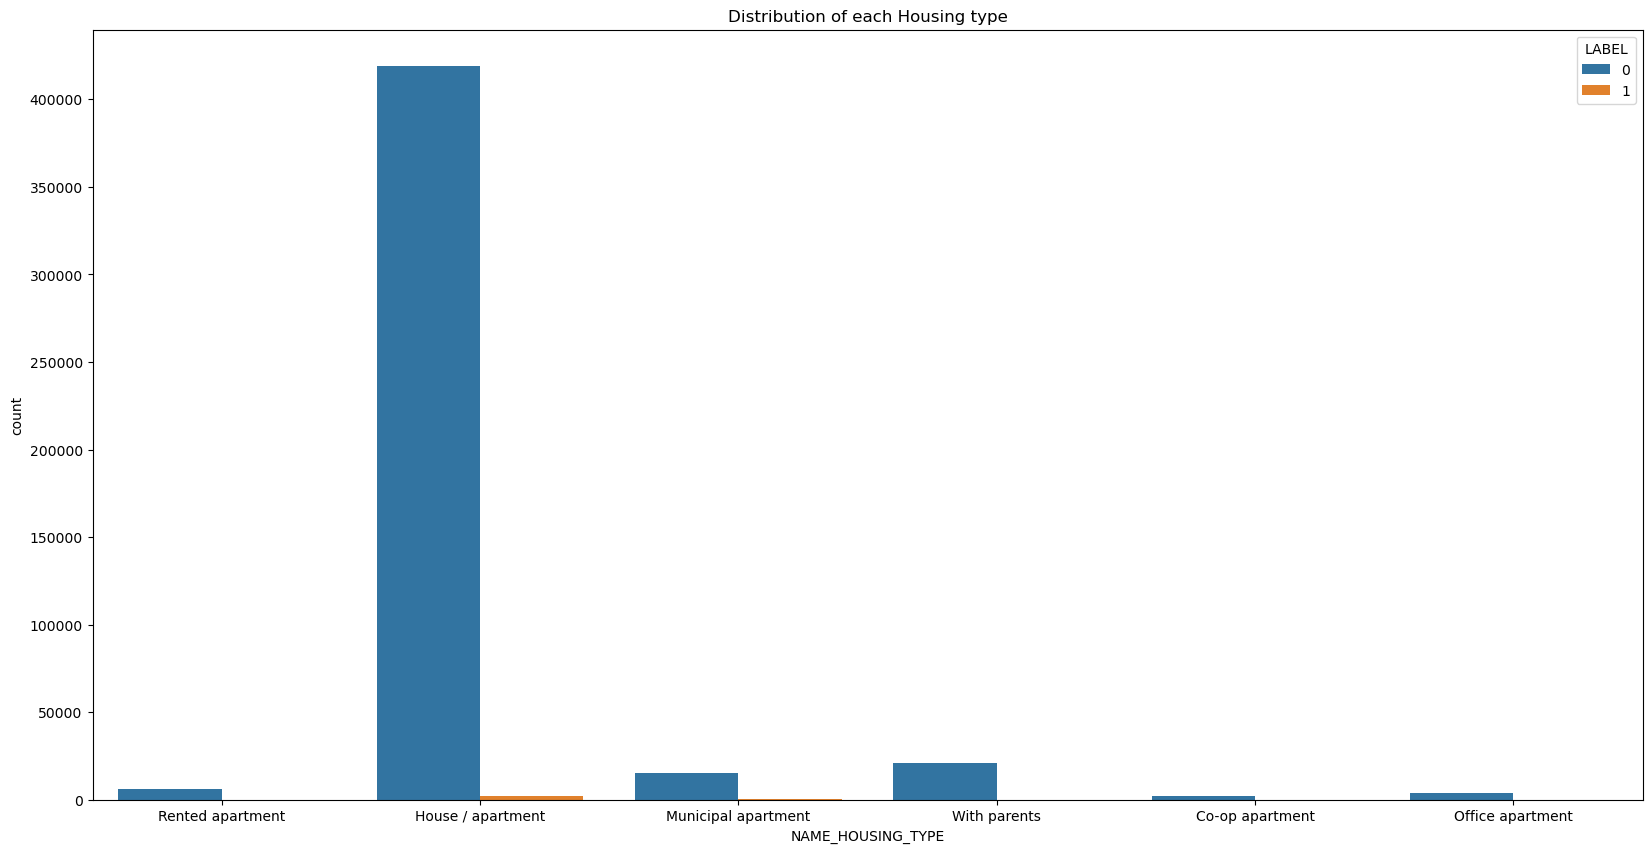

In [21]:
plt.figure(figsize=(20,10))
sns.countplot(x='NAME_HOUSING_TYPE', data=df,hue='LABEL')
plt.title('Distribution of each Housing type')
plt.show()

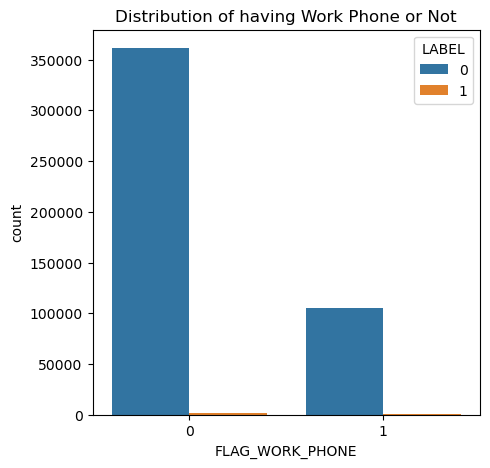

In [22]:
plt.figure(figsize=(5,5))
sns.countplot(x='FLAG_WORK_PHONE', data=df,hue='LABEL')
plt.title('Distribution of having Work Phone or Not')
plt.show()

In [23]:
plt.figure(figsize=(5,5))
sns.countplot(x='FLAG_PHONE', data=df,hue='LABEL')
plt.title('Distribution of having any Phone number or Not')
plt.show()

In [24]:
plt.figure(figsize=(5,5))
sns.countplot(x='FLAG_EMAIL', data=df,hue='LABEL')
plt.title('Distribution of having any EMAIL or Not')
plt.show()

In [25]:
# Convert categorical variables into dummy variables
df = pd.get_dummies(df, drop_first=True)

In [26]:
# Feature selection
X = df.drop('LABEL', axis=1)
y = df['LABEL']

In [27]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [30]:
# Use RandomForest for feature importance
rf_for_feat_imp = RandomForestClassifier(random_state=42).fit(X_train, y_train)
model = SelectFromModel(rf_for_feat_imp, prefit=True, threshold='mean')  # Use 'mean' as the threshold
X_train = model.transform(X_train)
X_test = model.transform(X_test)

In [31]:
# Fitting RandomForest classifier to the training set
rf_classifier = RandomForestClassifier(n_estimators=10, criterion="entropy")
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [32]:
# Predicting the test set results
y_pred = rf_classifier.predict(X_test)

In [33]:
# Creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[92815   447]
 [  352   171]]


In [34]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93262
           1       0.28      0.33      0.30       523

    accuracy                           0.99     93785
   macro avg       0.64      0.66      0.65     93785
weighted avg       0.99      0.99      0.99     93785



In [35]:
# https://www.kaggle.com/code/jainprathik/random-forest-and-xgboost-with-op?scriptVersionId=118603204&cellId=101
def rf_objective(trial):
    # define hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 2, 20),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    
    # create, train and validate model
    classifier = RandomForestClassifier(**params, random_state=42)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    return acc

study = optuna.create_study(direction="maximize")
study.optimize(rf_objective, n_trials=8)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-05-14 19:44:35,623] A new study created in memory with name: no-name-31e193f8-97f6-4ffa-bc50-96f52fb88df9
[I 2023-05-14 19:44:48,216] Trial 0 finished with value: 0.9835901263528283 and parameters: {'n_estimators': 4, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 0.9835901263528283.
[I 2023-05-14 19:45:03,358] Trial 1 finished with value: 0.5948392600095964 and parameters: {'n_estimators': 14, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.9835901263528283.
[I 2023-05-14 19:45:33,385] Trial 2 finished with value: 0.9747507597163726 and parameters: {'n_estimators': 8, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.9835901263528283.
[I 2023-05-14 19:45:57,602] Trial 3 finished with value: 0.9889108066321907 and parameters: {'n_estimators': 7, 'max_depth': 31, 'min_samples_split': 5, 

Number of finished trials:  8
Best trial:
  Value: 0.9889108066321907
  Params: 
    n_estimators: 7
    max_depth: 31
    min_samples_split: 5
    min_samples_leaf: 2
    bootstrap: True


In [36]:
# Final model
rf_final = RandomForestClassifier(**study.best_params, random_state=42)
rf_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=31, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=7, random_state=42)

In [37]:
# Fitting RandomForest classifier to the training set
rf_final_classifier = RandomForestClassifier(n_estimators=10, criterion="entropy")
rf_final_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [38]:
y_pred_train = rf_final.predict(X_train)
y_pred_test = rf_final.predict(X_test)

In [39]:
# Creating the confusion matrix for training set
cm_train = confusion_matrix(y_train, y_pred_train)
print(cm_train)

[[370819   2296]
 [   658 372457]]


In [40]:
# Creating the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

[[92447   815]
 [  225   298]]


In [41]:
# Print classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     93262
           1       0.27      0.57      0.36       523

    accuracy                           0.99     93785
   macro avg       0.63      0.78      0.68     93785
weighted avg       0.99      0.99      0.99     93785



In [42]:
# Evaluating the performance of the final model on training set
print("Training Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Training F1 Score: ", f1_score(y_train, y_pred_train))

Training Accuracy:  0.9960414349463302
Training F1 Score:  0.9960501050987607


Text(0.5, 63.222222222222186, 'Predicted label')

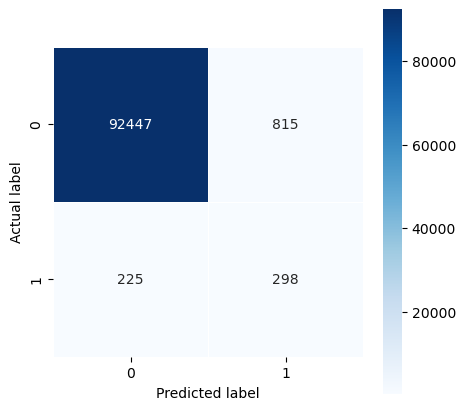

In [43]:
# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

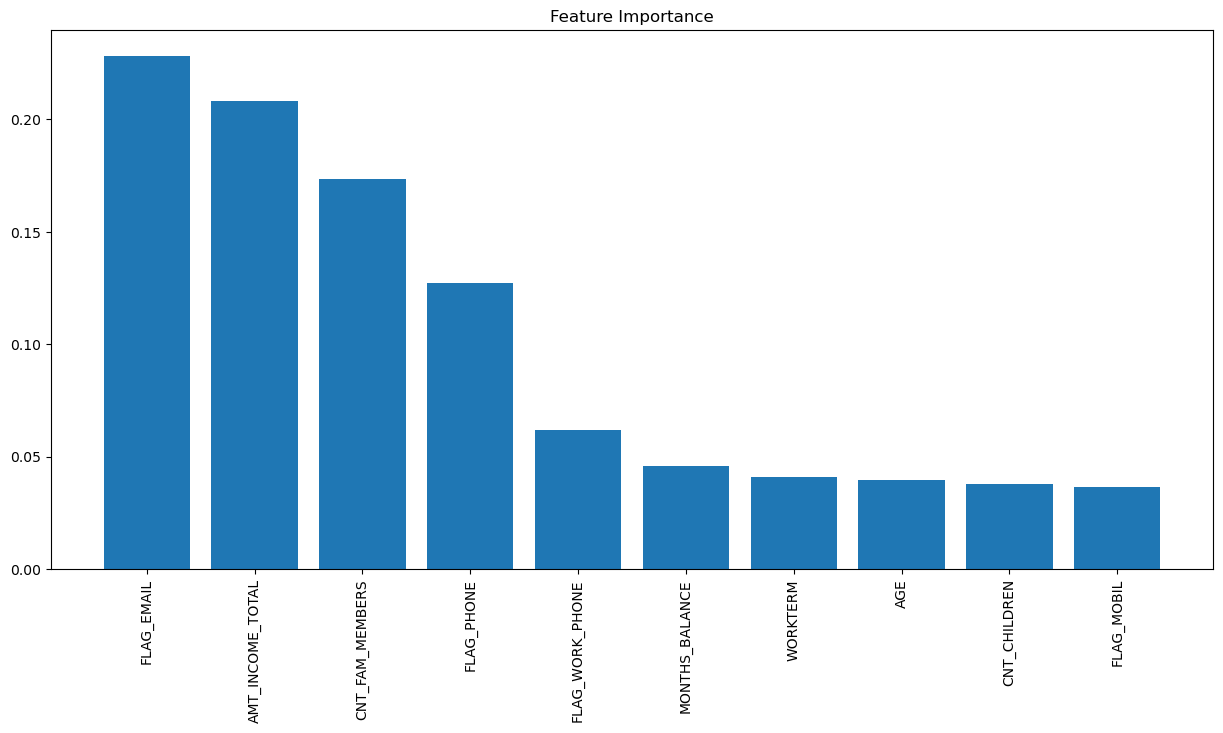

In [44]:
# Plotting the feature importance
importances = rf_final.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

In [46]:
# Save the model
joblib.dump(rf_final, 'rf_final_model.pkl')

['rf_final_model.pkl']